# Dynamicviz aligned PCA visualizations

Generates stacked/aligned PCA visualizations of the simulated data from `04_TISSUE_filtering_for_downstream_simulated_data.ipynb`.

This notebook requires a custom environment with DynamicViz that can be installed following the directions here: https://github.com/sunericd/dynamicviz. We also provide a yaml file with the conda environment that we run this notebook in: `environment_dynamicviz.yml`.

In [2]:
# install dynamicviz from https://github.com/sunericd/dynamicviz
from dynamicviz import viz, score

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import os
import pickle
import seaborn as sns
from scipy.spatial.transform import Rotation

### DynamicViz plotting (rigid alignment + stacked visualization)

In [5]:
# load results in from 04_TISSUE_filtering_for_downstream_simulated_data.ipynb
with open("results/clustering/REVISED_dynamicviz_simulated_50mix.pkl", "rb") as f:
    res_dict = pickle.load(f)

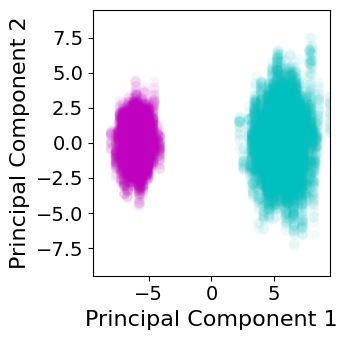

Setting up neighborhoods...
--- 0.023673534393310547 seconds ---
Populating distances...
--- 140.50472903251648 seconds ---
Computing mean pairwise distance for normalization...
--- 23.933768272399902 seconds ---
Computing variance scores...
--- 44.91001796722412 seconds ---


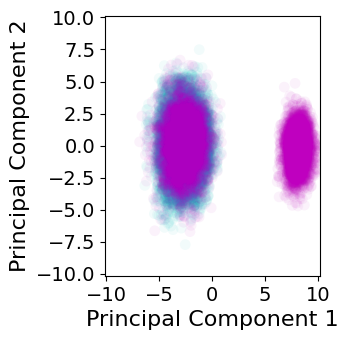

Setting up neighborhoods...
--- 0.026539325714111328 seconds ---
Populating distances...
--- 123.80215001106262 seconds ---
Computing mean pairwise distance for normalization...
--- 18.04475450515747 seconds ---
Computing variance scores...
--- 40.95439529418945 seconds ---


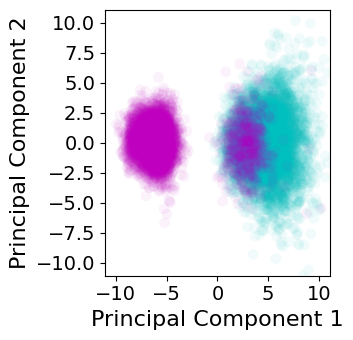

Setting up neighborhoods...
--- 0.022744178771972656 seconds ---
Populating distances...
--- 78.66451907157898 seconds ---
Computing mean pairwise distance for normalization...
--- 18.058030605316162 seconds ---
Computing variance scores...
--- 40.79164099693298 seconds ---


In [6]:
# Assemble formatted dataframe from results for DynamicViz
# Generate stacked visualization of PCA plots with DynamicViz

ref_idx = 5 # which one to align to (similar results regardless of choice here)

vscores = []
labels = []

for key in res_dict.keys():
    
    # Get dataframe from subdict of results
    df = pd.DataFrame.from_dict(res_dict[key])    
    
    # Rigid Alignment -- all original indices are in order so no need to map
    
    points0 = df[df["bootstrap_number"]==ref_idx][["x1","x2"]].values
    points0 = np.hstack((points0, np.zeros(points0.shape[0]).reshape(points0.shape[0],1)))
    points0[:,0] = points0[:,0]-np.mean(points0[:,0])
    points0[:,1] = points0[:,1]-np.mean(points0[:,1])
    
    indices0 = df[df["bootstrap_number"]==ref_idx]["original_index"].values
    
    # for each instance, align and save alignment
    for bnum in np.unique(df["bootstrap_number"]):
        points = df[df["bootstrap_number"]==bnum][["x1","x2"]].values
        points = np.hstack((points, np.zeros(points.shape[0]).reshape(points.shape[0],1)))
        points[:,0] = points[:,0]-np.mean(points[:,0])
        points[:,1] = points[:,1]-np.mean(points[:,1])
        
        indices = df[df["bootstrap_number"]==bnum]["original_index"].values
        
        # overlap indices
        overlap_indices = np.intersect1d(indices0, indices)
        pointsr = points[[np.where(indices==x)[0][0] for x in overlap_indices],:]
        points0r = points0[[np.where(indices0==x)[0][0] for x in overlap_indices],:]
        
        # rotate
        r = Rotation.align_vectors(points0r, pointsr)[0]
        rpoints = r.apply(points)
        
        # set new value
        df["x1"][df["bootstrap_number"]==bnum] = rpoints[:,0]
        df["x2"][df["bootstrap_number"]==bnum] = rpoints[:,1]        
        
    df["label"] = df["label"].astype(str)
    
    # Create DynamicViz using stacked modality
    fig = viz.stacked(df, 'label', show=True, colors=["c", "m"], width=3.5, height=3.5, s=60, alpha=0.05,
                      save=f"plots/scpi_clustering/REVISED_{key}_pc_plot_DYNAMICVIZ100.pdf",
                      xlabel="Principal Component 1", ylabel="Principal Component 2",
                      rasterized=True, show_legend=False, solid_legend=True)
    
    # Compute global variance score
    vscores.append(score.variance(df, method='global'))
    labels.append(key)

### Variance score (measure of visualization instability)

Lower scores imply more reliable/stable PCA visualizations.

In [11]:
# print mean and median variance scores for each approach
for vi, vscore in enumerate(vscores):
    print(labels[vi][0])
    print(np.mean(vscore))
    print(np.median(vscore))
    print("")

measured
0.00577434716385086
0.004922589287161827

imputed
0.4312206944722408
0.38108193082939

imputed-filtered
0.22299936155666106
0.19835998994189824



In [8]:
# set up dataframe for plotting
labels = [[labels[i]]*len(vscores[i]) for i in range(len(vscores))]

df = pd.DataFrame([])
df["Variance Score"] = np.concatenate(vscores)
df["Approach"] = np.concatenate(labels)

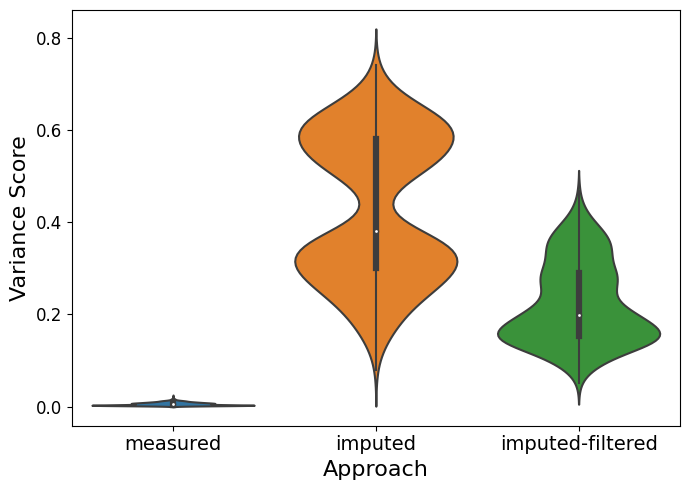

In [9]:
# violin plot of variance scores
plt.figure(figsize=(7,5))
sns.violinplot(x="Approach", y="Variance Score", data=df, scale='width')
plt.xlabel("Approach", fontsize=16)
plt.ylabel("Variance Score", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()